In [ ]:
# 📦 STEP 1: Install & Import Libraries
import os
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# 📁 STEP 2: Unzip Dataset
zip_path = "/content/trash_inst_material.zip"
extract_path = "/content/trash_inst_material"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content")

dataset_path = os.path.join(extract_path)  # -> /content/trash_inst_material


In [ ]:
class_names = {
    0: 'rov',
    1: 'plant',
    2: 'animal_fish',
    3: 'animal_starfish',
    4: 'animal_shells',
    5: 'animal_crab',
    6: 'animal_eel',
    7: 'animal_etc',
    8: 'trash_etc',
    9: 'trash_fabric',
    10: 'trash_fishing_gear',
    11: 'trash_metal',
    12: 'trash_paper',
    13: 'trash_plastic',
    14: 'trash_rubber',
    15: 'trash_wood',
}
num_classes = len(class_names)


In [ ]:
# 🧾 STEP 3: Define Dataset Class
class MarineWasteDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))
        self.labels = sorted(os.listdir(label_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.labels[idx])

        with open(label_path, 'r') as f:
            first_line = f.readline().strip()
            label = int(first_line.split()[0])  # ✅ Extract class index only

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


In [ ]:
train_dataset = MarineWasteDataset(
    image_dir='/content/trash_inst_material/train/images',
    label_dir='/content/trash_inst_material/train/labels',
    transform=transform
)

val_dataset = MarineWasteDataset(
    image_dir='/content/trash_inst_material/val/images',
    label_dir='/content/trash_inst_material/val/labels',
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# 🧠 STEP 4: Define CNN Model (from scratch)
class MarineCNN(nn.Module):
    def __init__(self, num_classes):
        super(MarineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [ ]:
# 🏋️ STEP 6: Train the Model
model = MarineCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")


Epoch [1/10], Loss: 424.2677
Epoch [2/10], Loss: 390.9886
Epoch [3/10], Loss: 380.2499
Epoch [4/10], Loss: 370.6975
Epoch [5/10], Loss: 360.8609
Epoch [6/10], Loss: 351.5662
Epoch [7/10], Loss: 342.0344
Epoch [8/10], Loss: 332.9430
Epoch [9/10], Loss: 325.8599
Epoch [10/10], Loss: 319.1344


In [ ]:
# ✅ STEP 7: Evaluate the Model
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {acc * 100:.2f}%")


Validation Accuracy: 30.32%


In [ ]:
# 💾 Optional: Save the model
torch.save(model.state_dict(), "marine_cnn_model.pth")
print("Model saved as 'marine_cnn_model.pth'")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# CNN Model with Dropout, BatchNorm, and increased layers
class MarineCNN(nn.Module):
    def __init__(self, num_classes):
        super(MarineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # First Conv Layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Second Conv Layer
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Third Conv Layer
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(64)  # BatchNorm after Conv1
        self.batchnorm2 = nn.BatchNorm2d(128) # BatchNorm after Conv2
        self.batchnorm3 = nn.BatchNorm2d(256) # BatchNorm after Conv3
        self.fc1 = nn.Linear(256 * 16 * 16, 512)  # Fully Connected layer
        self.fc2 = nn.Linear(512, num_classes)  # Output layer
        self.dropout = nn.Dropout(0.5)  # Dropout to prevent overfitting

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))  # Conv1 -> BatchNorm -> Pool
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))  # Conv2 -> BatchNorm -> Pool
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))  # Conv3 -> BatchNorm -> Pool
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Output layer
        return x

# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

# Initialize model
num_classes = 16  # Number of classes
model = MarineCNN(num_classes).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training Loop
epochs = 10
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation after each epoch
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate Validation Accuracy
    val_accuracy = 100 * correct / total
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Step the scheduler
    scheduler.step(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

# Load the best model after training
model.load_state_dict(torch.load('best_model.pth'))


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10], Training Loss: 349.3553, Validation Loss: 1.9071, Validation Accuracy: 41.20%
Epoch [2/10], Training Loss: 245.6139, Validation Loss: 1.7628, Validation Accuracy: 47.76%
Epoch [3/10], Training Loss: 204.0839, Validation Loss: 1.6940, Validation Accuracy: 51.50%
Epoch [4/10], Training Loss: 180.9748, Validation Loss: 1.6130, Validation Accuracy: 50.75%
Epoch [5/10], Training Loss: 162.5840, Validation Loss: 1.6194, Validation Accuracy: 51.66%
Epoch [6/10], Training Loss: 145.7943, Validation Loss: 1.6153, Validation Accuracy: 50.66%
Epoch [7/10], Training Loss: 134.6370, Validation Loss: 1.6197, Validation Accuracy: 51.33%
Epoch [8/10], Training Loss: 123.8026, Validation Loss: 1.5812, Validation Accuracy: 56.31%
Epoch [9/10], Training Loss: 113.0256, Validation Loss: 1.5863, Validation Accuracy: 55.48%
Epoch [10/10], Training Loss: 104.5318, Validation Loss: 1.6083, Validation Accuracy: 59.55%


<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# CNN Model with Dropout, BatchNorm, and increased layers
class MarineCNN(nn.Module):
    def __init__(self, num_classes):
        super(MarineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # First Conv Layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Second Conv Layer
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Third Conv Layer
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(64)  # BatchNorm after Conv1
        self.batchnorm2 = nn.BatchNorm2d(128) # BatchNorm after Conv2
        self.batchnorm3 = nn.BatchNorm2d(256) # BatchNorm after Conv3
        self.fc1 = nn.Linear(256 * 16 * 16, 512)  # Fully Connected layer
        self.fc2 = nn.Linear(512, num_classes)  # Output layer
        self.dropout = nn.Dropout(0.5)  # Dropout to prevent overfitting

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))  # Conv1 -> BatchNorm -> Pool
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))  # Conv2 -> BatchNorm -> Pool
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))  # Conv3 -> BatchNorm -> Pool
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Output layer
        return x

# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

# Initialize model
num_classes = 16  # Number of classes
model = MarineCNN(num_classes).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
# Define the number of epochs for training
epochs = 20
best_val_loss = float('inf')  # Initialize with a very high value

# Train the model for 20 epochs
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation after each epoch
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate Validation Accuracy
    val_accuracy = 100 * correct / total
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

# After 20 epochs, save the model as 'model_after_20_epochs.pth'
torch.save(model.state_dict(), 'model_after_20_epochs.pth')

# Load the best model based on validation loss (if needed)
model.load_state_dict(torch.load('best_model.pth'))


Epoch [1/20], Training Loss: 359.0849, Validation Loss: 1.9563, Validation Accuracy: 40.03%
Epoch [2/20], Training Loss: 252.8617, Validation Loss: 1.8547, Validation Accuracy: 40.86%
Epoch [3/20], Training Loss: 216.5745, Validation Loss: 1.7551, Validation Accuracy: 50.08%
Epoch [4/20], Training Loss: 185.8617, Validation Loss: 1.7090, Validation Accuracy: 48.09%
Epoch [5/20], Training Loss: 164.8740, Validation Loss: 1.6581, Validation Accuracy: 51.91%
Epoch [6/20], Training Loss: 145.2118, Validation Loss: 1.6633, Validation Accuracy: 50.00%
Epoch [7/20], Training Loss: 131.5246, Validation Loss: 1.5586, Validation Accuracy: 54.98%
Epoch [8/20], Training Loss: 125.7533, Validation Loss: 1.5741, Validation Accuracy: 57.06%
Epoch [9/20], Training Loss: 114.5234, Validation Loss: 1.6094, Validation Accuracy: 55.32%
Epoch [10/20], Training Loss: 108.7624, Validation Loss: 1.5767, Validation Accuracy: 57.14%
Epoch [11/20], Training Loss: 99.7776, Validation Loss: 1.6630, Validation Accu

<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

# CNN Model with Dropout, BatchNorm, and increased layers
class MarineCNN(nn.Module):
    def __init__(self, num_classes):
        super(MarineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # First Conv Layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Second Conv Layer
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # Third Conv Layer
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(64)  # BatchNorm after Conv1
        self.batchnorm2 = nn.BatchNorm2d(128) # BatchNorm after Conv2
        self.batchnorm3 = nn.BatchNorm2d(256) # BatchNorm after Conv3
        self.fc1 = nn.Linear(256 * 16 * 16, 512)  # Fully Connected layer
        self.fc2 = nn.Linear(512, num_classes)  # Output layer
        self.dropout = nn.Dropout(0.5)  # Dropout to prevent overfitting

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))  # Conv1 -> BatchNorm -> Pool
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))  # Conv2 -> BatchNorm -> Pool
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))  # Conv3 -> BatchNorm -> Pool
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected layer
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Output layer
        return x

# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

# Initialize model
num_classes = 16  # Number of classes
model = MarineCNN(num_classes).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Define the number of epochs for training
epochs = 20
best_val_loss = float('inf')  # Initialize with a very high value

# Train the model for 20 epochs
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation after each epoch
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate Validation Accuracy
    val_accuracy = 100 * correct / total
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Learning rate scheduler step
    scheduler.step(val_loss)

# After 20 epochs, save the model as 'newmodelafter20epochs.pth'
torch.save(model.state_dict(), 'newmodelafter20epochs.pth')

# Load the best model based on validation loss (if needed)
model.load_state_dict(torch.load('best_model.pth'))


Epoch [1/20], Training Loss: 336.3187, Validation Loss: 1.9426, Validation Accuracy: 43.77%
Epoch [2/20], Training Loss: 242.6428, Validation Loss: 1.8264, Validation Accuracy: 44.52%
Epoch [3/20], Training Loss: 206.1911, Validation Loss: 1.7515, Validation Accuracy: 50.91%
Epoch [4/20], Training Loss: 177.3664, Validation Loss: 1.6988, Validation Accuracy: 51.16%
Epoch [5/20], Training Loss: 163.1286, Validation Loss: 1.6460, Validation Accuracy: 55.07%
Epoch [6/20], Training Loss: 143.6511, Validation Loss: 1.5861, Validation Accuracy: 54.15%
Epoch [7/20], Training Loss: 134.9089, Validation Loss: 1.6091, Validation Accuracy: 54.40%
Epoch [8/20], Training Loss: 124.7112, Validation Loss: 1.7334, Validation Accuracy: 53.65%
Epoch [9/20], Training Loss: 115.3688, Validation Loss: 1.6911, Validation Accuracy: 56.64%
Epoch [10/20], Training Loss: 105.5406, Validation Loss: 1.6430, Validation Accuracy: 56.40%
Epoch [11/20], Training Loss: 89.6557, Validation Loss: 1.6431, Validation Accu

<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CNN Model with 5 Conv Layers, Dropout, BatchNorm
class MarineCNN(nn.Module):
    def __init__(self, num_classes):
        super(MarineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.batchnorm5 = nn.BatchNorm2d(512)

        self.dropout = nn.Dropout(0.5)

        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))
        x = self.pool(F.relu(self.batchnorm5(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

# NOTE: You need to define your `train_loader` and `val_loader` here with the proper dataset and transform

# Initialize model
num_classes = 16  # Number of classes in your dataset
model = MarineCNN(num_classes).to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Define the number of epochs for training
epochs = 20
best_val_loss = float('inf')

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    # Step the scheduler
    scheduler.step(val_loss)

# Save final model after training
torch.save(model.state_dict(), 'newmodelafter20epochs5layers.pth')

# Load best model (optional)
model.load_state_dict(torch.load('best_model.pth'))


Epoch [1/20], Training Loss: 308.3628, Validation Loss: 1.8473, Validation Accuracy: 43.60%
Epoch [2/20], Training Loss: 220.8963, Validation Loss: 1.7812, Validation Accuracy: 45.18%
Epoch [3/20], Training Loss: 175.7063, Validation Loss: 1.6777, Validation Accuracy: 49.50%
Epoch [4/20], Training Loss: 144.9549, Validation Loss: 1.6612, Validation Accuracy: 53.65%
Epoch [5/20], Training Loss: 124.5007, Validation Loss: 1.6574, Validation Accuracy: 53.57%
Epoch [6/20], Training Loss: 109.2752, Validation Loss: 1.6541, Validation Accuracy: 57.06%
Epoch [7/20], Training Loss: 96.6339, Validation Loss: 1.5907, Validation Accuracy: 59.30%
Epoch [8/20], Training Loss: 87.4592, Validation Loss: 1.5457, Validation Accuracy: 62.71%
Epoch [9/20], Training Loss: 79.3791, Validation Loss: 1.4819, Validation Accuracy: 60.71%
Epoch [10/20], Training Loss: 71.1143, Validation Loss: 1.6892, Validation Accuracy: 58.14%
Epoch [11/20], Training Loss: 66.1013, Validation Loss: 1.5736, Validation Accuracy

<All keys matched successfully>

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class YOLOImageFolder(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]  # Assuming .jpg files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        label_path = os.path.join(self.labels_dir, image_name.replace('.jpg', '.txt'))  # Assuming labels are in .txt files

        # Load image
        image = Image.open(image_path).convert('RGB')

        # Load label
        with open(label_path, 'r') as file:
            labels = file.readlines()

        # Convert YOLO labels (class, x_center, y_center, width, height) to class indices
        class_labels = []
        for label in labels:
            class_labels.append(int(label.split()[0]))  # Assuming the first value is the class index

        # Apply transformations if defined
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(class_labels)  # Return the image and its labels as tensor



In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms

# Define your transforms (must match training)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Custom collate function to handle variable length labels
def collate_fn(batch):
    images, labels = zip(*batch)

    # Stack the images (as usual)
    images = torch.stack(images, 0)

    # Find the maximum length of labels in this batch
    max_len = max(len(label) for label in labels)

    # Pad the labels to the maximum length
    padded_labels = []
    for label in labels:
        padding = max_len - len(label)
        padded_label = torch.cat([label, torch.zeros(padding, dtype=torch.long)])  # Pad with zeros
        padded_labels.append(padded_label)

    # Stack the labels
    labels = torch.stack(padded_labels, 0)

    return images, labels

# Define the model (with the correct architecture)
class MarineCNN(nn.Module):
    def __init__(self, num_classes):
        super(MarineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.batchnorm5 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))
        x = self.pool(F.relu(self.batchnorm5(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and weights
model = MarineCNN(num_classes=16).to(device)
model.load_state_dict(torch.load("/content/newmodelafter20epochs5layers.pth"))
model.eval()

# Dataset and loader
val_images_path = '/content/trash_inst_material/val/images'
val_labels_path = '/content/trash_inst_material/val/labels'

# Instantiate the custom dataset
val_dataset = YOLOImageFolder(images_dir=val_images_path, labels_dir=val_labels_path, transform=test_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Evaluation loop
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Loop over the batch to evaluate each object
        for i in range(images.size(0)):
            predicted_class = torch.argmax(outputs[i]).item()  # Get predicted class for the image
            true_labels = labels[i]

            # Count correct predictions for the objects in the image
            correct += (true_labels == predicted_class).sum().item()  # Compare with the ground truth
            total += len(true_labels)  # Total number of objects to compare

print(f"Validation Accuracy: {100 * correct / total:.2f}%")


Validation Accuracy: 31.21%


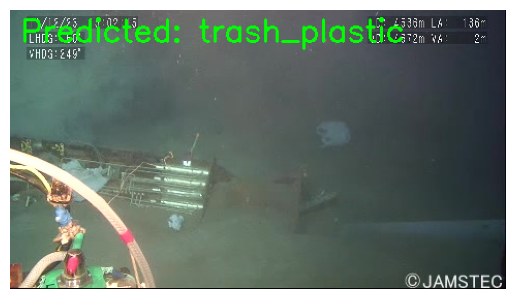

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Define the image transform (must match the one used during training)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize for model input
    transforms.ToTensor(),
])

# Load the trained model
model = MarineCNN(num_classes=16).to(device)
model.load_state_dict(torch.load("/content/newmodelafter20epochs5layers.pth"))
model.eval()

# Load input image (replace with your path)
image_path = '/content/trash_inst_material/train/images/vid_000120_frame0000018.jpg'
image = Image.open(image_path).convert('RGB')

# Apply transformations to the image (resizing and converting to tensor for the model)
input_image = transform(image).unsqueeze(0).to(device)

# Run the image through the model
with torch.no_grad():
    outputs = model(input_image)

# Get predicted class
_, predicted_class = torch.max(outputs, 1)

# For visualization, keep the original image size
original_image = cv2.imread(image_path)

# Optionally, use a predefined color map or assign colors to different classes
class_names = ['rov', 'plant', 'animal_fish', 'animal_starfish', 'animal_shells', 'animal_crab',
               'animal_eel', 'animal_etc', 'trash_etc', 'trash_fabric', 'trash_fishing_gear',
               'trash_metal', 'trash_paper', 'trash_plastic', 'trash_rubber', 'trash_wood']

# Add text on the original image to display the predicted class
label = predicted_class.item()
cv2.putText(original_image, f'Predicted: {class_names[label]}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Show the original image with the prediction (correct size)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide the axes for a cleaner view
plt.show()
